# Get dataset

In [1]:
# see https://github.com/KangchengHou/admix-kit for installation
import admix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pull simulated dataset

In [2]:
# the following link is generated from workflow
SRC_DATA_PREFIX = \
    "gs://fc-de85480c-3b81-412d-838f-808954922b60/submissions/5f89d735-b1f4-4e90-9aea-9cf43e54a24b/" + \
    "sim_admixed/9813f990-232d-4fa0-bf3c-c55d801228e0"

In [3]:
%%capture

DATA_DIR = "./analysis"
!mkdir -p {DATA_DIR}

# transfer simulated admixed dataset
!gsutil cp {SRC_DATA_PREFIX}/call-admix_simu/*/cacheCopy/admix_chr* {DATA_DIR}/
# transfer simulated 1kg dataset
!gsutil cp -r {SRC_DATA_PREFIX}/call-subset_hapmap3/*/cacheCopy/hm3_chr* {DATA_DIR}/

In [4]:
# We simulate two datasets with chromosomes 1,2
# 1. admix_: Admixed individuals
# 2. hm3_: 1,000 Genomes individuals in HapMap3 variants
!ls {DATA_DIR}/

admix_chr1.lanc		 admix_merged.psam	hm3_merged-merge.pvar
admix_chr1.pgen		 admix_merged.pvar	hm3_merged.pgen
admix_chr1.psam		 hm3_chr1.frq.strat	hm3_merged.psam
admix_chr1.pvar		 hm3_chr1.log		hm3_merged.pvar
admix_chr2.lanc		 hm3_chr1.pgen		merged.bed
admix_chr2.pgen		 hm3_chr1.psam		merged.bim
admix_chr2.psam		 hm3_chr1.pvar		merged.fam
admix_chr2.pvar		 hm3_chr2.pgen		merged.log
admix_merged.log	 hm3_chr2.psam		merged.nosex
admix_merged-merge.pgen  hm3_chr2.pvar		merged.pca.eigenval
admix_merged-merge.psam  hm3_merged.log		merged.pca.eigenvec
admix_merged-merge.pvar  hm3_merged-merge.pgen	merged.pca.log
admix_merged.pgen	 hm3_merged-merge.psam


# Visualize local ancestry

/home/jupyter/admix-kit/admix/plot/_plot.py:346: UserWarning: Only the first 10 are plotted. To plot more individuals, increase `max_indiv`
  f"Only the first {n_plot_indiv} are plotted. To plot more individuals, increase `max_indiv`"


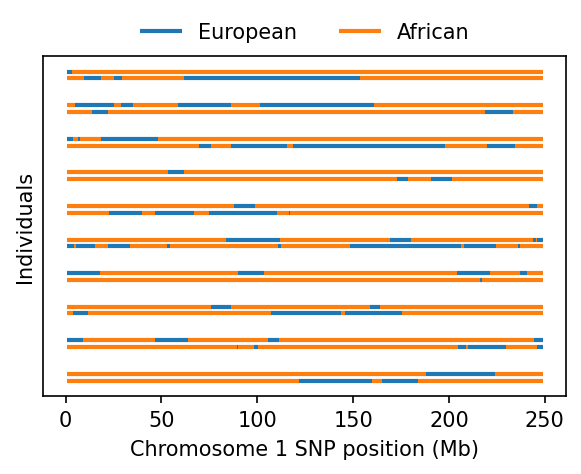

In [5]:
# plot local ancestry on chromosome 1 for the first 10 individuals 
dset = admix.io.read_dataset(f"{DATA_DIR}/admix_chr1")

fig, ax = plt.subplots(figsize=(4.5, 3), dpi=150)
admix.plot.lanc(dset=dset)
ax.legend(
    loc='center', 
    bbox_to_anchor=(0.5, 1.07), 
    ncol=2, 
    labels=["European", "African"], 
    frameon=False
)
ax.set_xlabel("Chromosome 1 SNP position (Mb)")
fig.show()

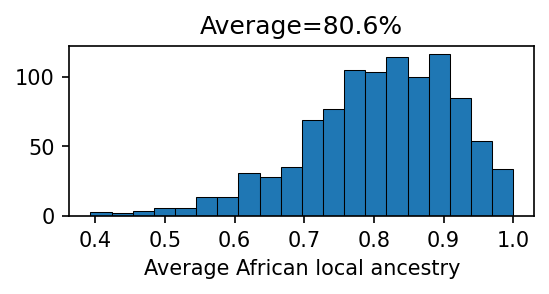

In [6]:
# plot the average local ancestry on chromosome 1
lanc = dset.lanc.compute()
avg_lanc = lanc.mean(axis=(0, 2))
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=150)
ax.hist(avg_lanc, bins=20, edgecolor="black", linewidth=0.5)
ax.set_xlabel("Average African local ancestry")
ax.set_title(f"Average={avg_lanc.mean() * 100:.1f}%")
fig.show()

# PCA plot of simulated admixed genotype together with 1,000 Genomes project

In [7]:
%%capture

# merge SNPs in one file
!plink2 --pfile {DATA_DIR}/hm3_chr1 --pmerge {DATA_DIR}/hm3_chr2 --make-pgen --out {DATA_DIR}/hm3_merged
!plink2 --pfile {DATA_DIR}/admix_chr1 --pmerge {DATA_DIR}/admix_chr2 --make-pgen --out {DATA_DIR}/admix_merged

# merge 1kg dataset and simulated dataset
!admix pfile-merge-indiv \
    --pfile1 {DATA_DIR}/hm3_merged \
    --pfile2 {DATA_DIR}/admix_merged \
    --out {DATA_DIR}/merged

# perform PCA
!plink2 --bfile {DATA_DIR}/merged \
    --pca \
    --out {DATA_DIR}/merged.pca

In [8]:
def read_pca(ref_pfile, pca_prefix):
    pop_df = pd.read_csv(ref_pfile + ".psam", delim_whitespace=True, index_col=0)

    pca_df = (
        pd.read_csv(f"{pca_prefix}.eigenvec", delim_whitespace=True)
        .set_index("IID")
        .drop(columns=["#FID"])
    )

    pca_df["SUPERPOP"] = pop_df["SuperPop"].reindex(pca_df.index)
    pca_df["POP"] = pop_df["Population"].reindex(pca_df.index)
    pca_df["SUPERPOP"] = pca_df["SUPERPOP"].fillna("Simulated")
    pca_df["POP"] = pca_df["POP"].fillna("Simulated")
    return pca_df

def plot_pca(pca_df):
    color_dict = {
        "EUR": "C1",
        "AFR": "C0",
        "EAS": "C2",
        "SAS": "C3",
        "AMR": "C4",
        "Simulated": "black",
    }
    
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    
    for group in color_dict:
        group_df = pca_df[pca_df["SUPERPOP"] == group]
        s = 20 if group == "Simulated" else 1
        alpha = 0.1 if group == "Simulated" else 1
        ax.scatter(group_df["PC1"], group_df["PC2"], s=s, alpha=alpha, label=group, c=color_dict[group])

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    legend = ax.legend(frameon=False)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
        lh.set_sizes([30])

    return fig, ax

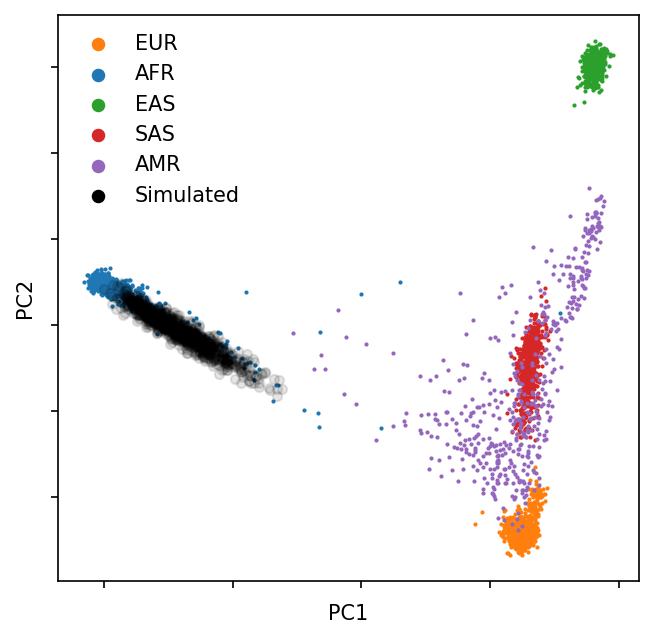

In [9]:
pca_df = read_pca(
    ref_pfile=f"{DATA_DIR}/hm3_merged", 
    pca_prefix=f"{DATA_DIR}/merged.pca"
)
fig, ax = plot_pca(pca_df)

# Consistency of ancestry-specific allele frequency

In [10]:
dset = admix.io.read_dataset(f"{DATA_DIR}/admix_chr1")
admix_freq_df = pd.DataFrame(
    dset.af_per_anc(), 
    index=dset.snp.index, 
    columns=["EUR", "AFR"]
)

admix.data.af_per_anc: 100%|██████████| 85/85 [00:09<00:00,  8.90it/s]


In [11]:
%%capture
!admix pfile-freq-within --pfile {DATA_DIR}/hm3_chr1 --group-col Population --out {DATA_DIR}/hm3_chr1
ref_freq_df = pd.read_csv(f"{DATA_DIR}/hm3_chr1.frq.strat", delim_whitespace=True)

In [12]:
# allele frequency calculated within local ancestry
admix_freq_df

,EUR,AFR
snp,,
1:817341:A:G,0.807882,0.266625
1:818802:A:G,0.827586,0.352572
1:825532:C:T,0.778870,0.424984
1:833068:G:A,0.120393,0.069052
1:843942:A:G,0.164619,0.499058
...,...,...
1:248873491:T:C,0.057592,0.172435
1:248876512:G:T,0.157068,0.804079
1:248908368:C:T,0.073298,0.199629


In [13]:
# allele frequency calculated in each of the
# reference population in 1,000 genomes
ref_freq_df

,CHR,SNP,CLST,A1,A2,MAF,MAC,NCHROBS
0,1,1:817341:A:G,ACB,A,G,0.67710,130,192
1,1,1:817341:A:G,ASW,A,G,0.58930,66,112
2,1,1:817341:A:G,BEB,A,G,0.22280,45,202
3,1,1:817341:A:G,CDX,A,G,0.22040,41,186
4,1,1:817341:A:G,CEU,A,G,0.16800,41,244
...,...,...,...,...,...,...,...,...
2261839,1,1:248917151:T:C,PJL,C,T,0.04327,9,208
2261840,1,1:248917151:T:C,PUR,C,T,0.02404,5,208
2261841,1,1:248917151:T:C,STU,C,T,0.02427,5,206
2261842,1,1:248917151:T:C,TSI,C,T,0.03271,7,214


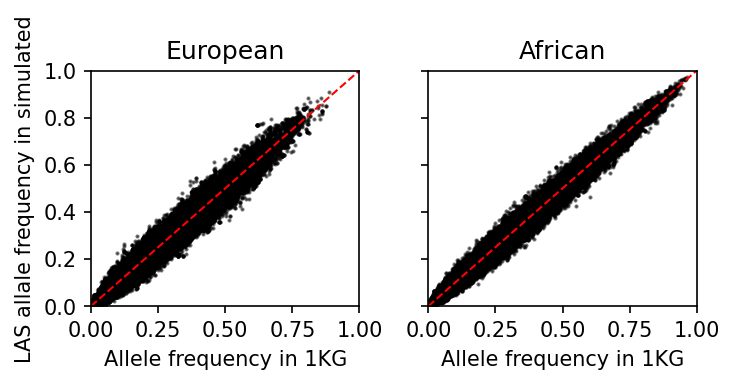

In [14]:
fig, axes = plt.subplots(figsize=(5,2.5), dpi=150, ncols=2, sharey=True)

for i, (ref_name, name) in enumerate(
    zip(["CEU", "YRI"], ["EUR", "AFR"])
):
    
    freq_df = ref_freq_df[ref_freq_df.CLST == ref_name].reset_index(drop=True).rename(
        columns={"CHR": "CHROM", "A1": "ALT", "A2": "REF"}
    )
    freq_df["POS"] = freq_df["SNP"].apply(lambda s : int(s.split(':')[1]))
    freq1 = freq_df["MAF"].values
    freq2 = admix_freq_df[name].values.copy()
    
    diff_allele = dset.snp.ALT.values != freq_df.ALT.values
    freq2[diff_allele] = 1 - freq2[diff_allele]
    ax = axes[i]
    ax.scatter(freq1, freq2, s=1, color='black', alpha=0.5)
    ax.axline((0.5, 0.5), slope=1, color='red', ls='--', lw=1)
    ax.set_xlabel("Allele frequency in 1KG")

    ax.set_title({"CEU": "European", "YRI": "African"}[ref_name])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    if i == 0:
        ax.set_ylabel("LAS allale frequency in simulated")
    
fig.tight_layout()
fig.show()